In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn import metrics
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor
from sklearn.metrics import confusion_matrix

cudnn.benchmark = True
plt.ion() 

In [2]:
model = models.mobilenet_v3_small(pretrained=False)

/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------


train Loss: 6.2168 Acc: 0.5500
val Loss: 6.2017 Acc: 0.5000

Epoch 1/9
----------
train Loss: 1.8070 Acc: 0.5650
val Loss: 4.6785 Acc: 0.5000

Epoch 2/9
----------
train Loss: 0.5829 Acc: 0.7259
val Loss: 2.8817 Acc: 0.5000

Epoch 3/9
----------
train Loss: 0.3614 Acc: 0.8564
val Loss: 1.1516 Acc: 0.5143

Epoch 4/9
----------
train Loss: 0.2901 Acc: 0.8800
val Loss: 0.7022 Acc: 0.7571

Epoch 5/9
----------
train Loss: 0.2280 Acc: 0.9168
val Loss: 0.1430 Acc: 0.9457

Epoch 6/9
----------
train Loss: 0.1889 Acc: 0.9250
val Loss: 0.3090 Acc: 0.9071

Epoch 7/9
----------
train Loss: 0.1659 Acc: 0.9418
val Loss: 0.0862 Acc: 0.9714

Epoch 8/9
----------
train Loss: 0.1704 Acc: 0.9314
val Loss: 0.0594 Acc: 0.9814

Epoch 9/9
----------
train Loss: 0.1274 Acc: 0.9564
val Loss: 0.0638 Acc: 0.9814

Training complete in 4m 60s
Best val Acc: 0.981429


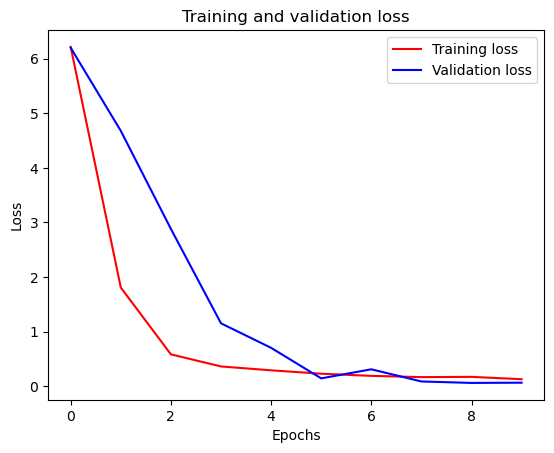

In [21]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), 'best_model/modelv301.pt')

In [3]:
# model_state_dict = torch.load('best_model_final_dataset/model04.pt')

model_state_dict = torch.load('best_model/modelv301.pt' , map_location=torch.device('cpu'))    ##for cpu only

model_ft = models.mobilenet_v3_small(pretrained=False)

# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft.load_state_dict(model_state_dict)
model_ft.eval()

/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
def Prediction(image_path):
    image = Image.open(image_path)
    image_tensor = toTensor(image)
    image_tensor = image_tensor.float()
    
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
    input = Variable(image_tensor).to(device)

    output = model_ft(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = class_names[index]
    
    return pred
toTensor = transforms.ToTensor()

In [5]:
Prediction("demo_img/400336.png")

'Not_Signature_card'

In [6]:
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('dataset/test', transform=val_transforms)

valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [7]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

In [8]:
tp = cm[0, 0]
fp = cm[1, 0]
fn = cm[0, 1]
tn = cm[1, 1]

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision.item())
print("Recall:", recall.item())
print("F1 Score:", f1_score.item())

print(tp)
print(fp)
print(fn)
print(tn)

Precision: 0.9896907216494846
Recall: 0.96
F1 Score: 0.9746192893401014
192
2
8
198


In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

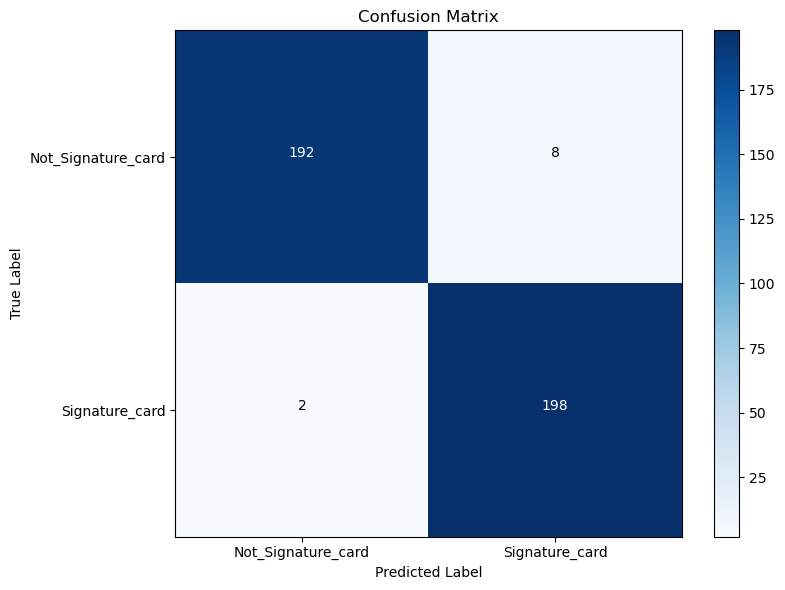

In [10]:
# Example confusion matrix values
confusion_matrix = np.array([[50, 10], [15, 75]])
classes = class_names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, normalize=False)
plt.show()

In [11]:
real_label = []
pred_label = []

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
#             inputs = FaceCrop(inputs)
#             image_tensor = toTensor(inputs)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_label.append(labels)
            pred_label.append(predicted)
    return correct / total

In [12]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([255,255])
])

tests_path = r'dataset/test'

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100
)

In [13]:
accuracy = evaluate(model_ft, test_dataloader)
accuracy


/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7775